In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from collections import Counter
from spacy.lang.en.stop_words import STOP_WORDS 
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import regex as re
import nltk
from nltk import ne_chunk, pos_tag, word_tokenize
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

2024-06-20 13:47:52.673062: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_common_words(balanced_df, column_genre='genre', column_lyrics='processed_lyrics', top_n=10):
    genre_words = {}

    # Coletar todas as palavras por gênero
    for genre in balanced_df[column_genre].unique():
        lyrics = ' '.join(balanced_df[balanced_df[column_genre] == genre][column_lyrics])
        words = lyrics.split()
        genre_words[genre] = words

    # Contar as palavras mais comuns por gênero
    genre_word_counts = {genre: Counter(words) for genre, words in genre_words.items()}

    # Criar subplots para os gráficos de barras
    num_genres = len(genre_word_counts)
    fig, axs = plt.subplots((num_genres + 1) // 2, 2, figsize=(15, 20)) 
    axs = axs.flatten()

    # Plotar as palavras mais comuns para cada gênero
    for ax, (genre, word_count) in zip(axs, genre_word_counts.items()):
        common_words = word_count.most_common(top_n)
        words, counts = zip(*common_words)
        ax.bar(words, counts)
        ax.set_title(f'Common Words in {genre} Songs')
        ax.set_xticklabels(words, rotation=45)

    plt.tight_layout()
    plt.show()


In [3]:
# nlp = spacy.load("en_core_web_lg")

DATA_PATH = '/home/paulo/anaconda3/envs/studies/TMCI_Project-master/lyrics.csv' 
df_full = pd.read_csv(DATA_PATH)
df_full = df_full.dropna()
df_full = df_full.drop(df_full.loc[(df_full['year'] < 1900) | (df_full['year'] > 2024)].index)
df_full = df_full.drop(df_full[(df_full['genre'] == 'Not Available') | (df_full['genre'] == 'Other')].index)

In [4]:
df = df_full[['lyrics', 'genre']]



def clean_lyrics(text):
    text = re.sub(r'[^A-Za-z ]', ' ', text)
    
    words = text.split()  
    
    if len(words) < 3: # Remover letras com menos de 3 palavras
        return ''
    text = ' '.join(words)
    
    text = text.strip()
    
    
    return text
 
    
df_full['clean_lyrics'] = df_full['lyrics'].apply(clean_lyrics)

df_clean = df_full[df_full['clean_lyrics'] != ""]
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233220 entries, 0 to 362236
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         233220 non-null  int64 
 1   song          233220 non-null  object
 2   year          233220 non-null  int64 
 3   artist        233220 non-null  object
 4   genre         233220 non-null  object
 5   lyrics        233220 non-null  object
 6   clean_lyrics  233220 non-null  object
dtypes: int64(2), object(5)
memory usage: 14.2+ MB


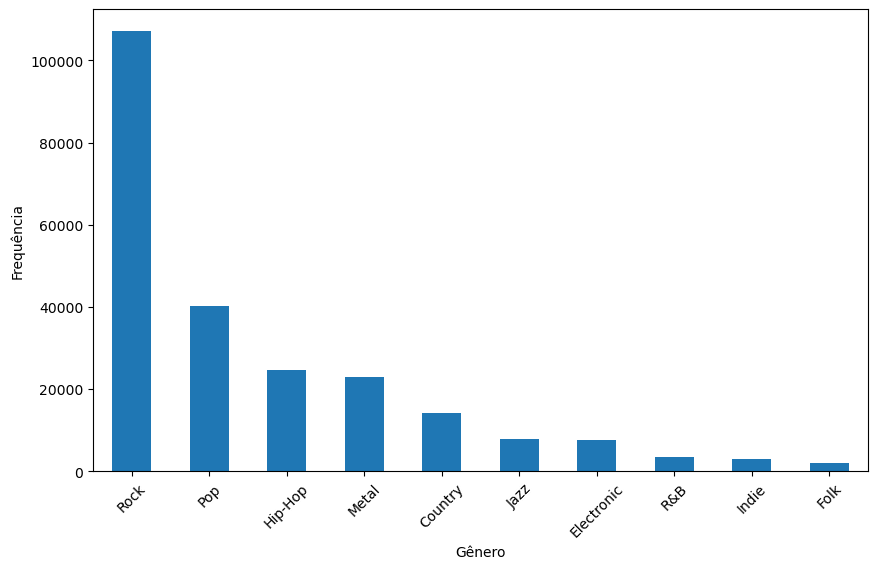

In [5]:
genre_frequency = df_clean['genre'].value_counts()

plt.figure(figsize=(10, 6))
genre_frequency.plot(kind='bar')
plt.xlabel('Gênero')
plt.ylabel('Frequência')
plt.xticks(rotation=45) 
plt.show()

In [6]:
df_clean['genre'].value_counts()

genre
Rock          107060
Pop            40198
Hip-Hop        24754
Metal          22897
Country        14322
Jazz            7823
Electronic      7580
R&B             3390
Indie           3101
Folk            2095
Name: count, dtype: int64

In [5]:
def balance_classes(df, target_column, max_instances):
    balanced_df = pd.DataFrame()
    for class_label, group in df.groupby(target_column):
        if len(group) > max_instances:
            group = group.assign(word_count=group[target_column].apply(lambda x: len(str(x).split())))
            group = group.sort_values(by='word_count', ascending=False).head(max_instances)
        balanced_df = pd.concat([balanced_df, group])
    return balanced_df

In [7]:
max_instances_per_class = 3390
balanced_df = balance_classes(df_clean, 'genre',max_instances_per_class)

In [8]:
balanced_df['genre'].value_counts()

genre
Country       3390
Electronic    3390
Hip-Hop       3390
Jazz          3390
Metal         3390
Pop           3390
R&B           3390
Rock          3390
Indie         3101
Folk          2095
Name: count, dtype: int64

# Preprocessing Pipeline:

In [9]:
def remove_tabs_new_line(lyrics):
    string = re.sub(r"\s+"," ",lyrics)
    string = re.sub(r"[/]"," ",string)
    return string

def decontractions(lyrics):
    decontracted = re.sub(r"won\'t", "will not", lyrics)
    decontracted = re.sub(r"can\'t", "can not", decontracted)
    decontracted = re.sub(r"n\'t", " not", decontracted)
    decontracted = re.sub(r"\'re", " are", decontracted)
    decontracted = re.sub(r"\'s", " is", decontracted)
    decontracted = re.sub(r"\'d", " would", decontracted)
    decontracted = re.sub(r"\'ll", " will", decontracted)
    decontracted = re.sub(r"\'t", " not", decontracted)
    decontracted = re.sub(r"\'ve", " have", decontracted)
    decontracted = re.sub(r"\'m", " am", decontracted)
    decontracted = re.sub(r"ain\'t", "is not", decontracted)
    decontracted = re.sub(r"\'cause", "because", decontracted)
    decontracted = re.sub(r"y\'all", "you all", decontracted)
    decontracted = re.sub(r"ma\'am", "madam", decontracted)
    decontracted = re.sub(r"o\'clock", "of the clock", decontracted)
    decontracted = re.sub(r"gonna", "going to", decontracted)
    decontracted = re.sub(r"wanna", "want to", decontracted)
    decontracted = re.sub(r"gotta", "got to", decontracted)
    decontracted = re.sub(r"let\'s", "let us", decontracted)
    decontracted = re.sub(r"how\'d", "how did", decontracted)
    decontracted = re.sub(r"how\'ll", "how will", decontracted)
    decontracted = re.sub(r"how\'s", "how is", decontracted)
    decontracted = re.sub(r"what\'d", "what did", decontracted)
    decontracted = re.sub(r"what\'ll", "what will", decontracted)
    decontracted = re.sub(r"what\'re", "what are", decontracted)
    decontracted = re.sub(r"what\'s", "what is", decontracted)
    decontracted = re.sub(r"what\'ve", "what have", decontracted)
    decontracted = re.sub(r"where\'d", "where did", decontracted)
    decontracted = re.sub(r"where\'ll", "where will", decontracted)
    decontracted = re.sub(r"where\'re", "where are", decontracted)
    decontracted = re.sub(r"where\'s", "where is", decontracted)
    decontracted = re.sub(r"where\'ve", "where have", decontracted)
    decontracted = re.sub(r"who\'d", "who did", decontracted)
    decontracted = re.sub(r"who\'ll", "who will", decontracted)
    decontracted = re.sub(r"who\'re", "who are", decontracted)
    decontracted = re.sub(r"who\'s", "who is", decontracted)
    decontracted = re.sub(r"who\'ve", "who have", decontracted)
    decontracted = re.sub(r"why\'d", "why did", decontracted)
    decontracted = re.sub(r"why\'ll", "why will", decontracted)
    decontracted = re.sub(r"why\'re", "why are", decontracted)
    decontracted = re.sub(r"why\'s", "why is", decontracted)
    decontracted = re.sub(r"why\'ve", "why have", decontracted)
    decontracted = re.sub(r"that\'d", "that would", decontracted)
    decontracted = re.sub(r"that\'ll", "that will", decontracted)
    decontracted = re.sub(r"that\'re", "that are", decontracted)
    decontracted = re.sub(r"that\'s", "that is", decontracted)
    decontracted = re.sub(r"that\'ve", "that have", decontracted)
    return decontracted

def lower_case(lyrics):
    return lyrics.lower() 

def is_english(lyrics):
    try:
        detect(lyrics) == 'en'
        return lyrics
    except:
        return ''
    
def remove_stopwords(tokens):  
    tokens_without_stopwords = [word for word in tokens if word not in STOP_WORDS]
    return tokens_without_stopwords

def remove_short_words(tokens, N):
    filtered_lyrics = [word for word in tokens if len(word) > N]  # Filtra palavras com tamanho >= N
    return filtered_lyrics

def remove_repeated_words(tokens):
    unique_words = []
    seen_words = set()
    for word in tokens:
        if word not in seen_words:
            unique_words.append(word)
            seen_words.add(word)
    return unique_words

def final_processing(lyrics):  
    string = re.sub(r'[^a-z\s]', '', lyrics)
    string = re.sub(r'\bverse\b', '', string)
    string = re.sub(r'\bchorus\b', '', string)
    string = re.sub(r'\s+', ' ', string).strip()
    return string

In [10]:
def preprocess_pipeline(lyrics):
    lyrics = remove_tabs_new_line(lyrics)
    lyrics = lower_case(lyrics)
    #lyrics = is_english(lyrics)
    lyrics = decontractions(lyrics) # Decontractions like: I've -> I have
    tokens = word_tokenize(lyrics) 
    tokens = remove_stopwords(tokens)
    tokens = remove_short_words(tokens, N=2)
    tokens = remove_repeated_words(tokens)
    lyrics = ' '.join(tokens)
    lyrics = final_processing(lyrics)
    
    return lyrics

In [11]:
balanced_df['processed_lyrics'] = balanced_df['lyrics'].apply(preprocess_pipeline)


/tmp/ipykernel_5155/2237043858.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=45)
/tmp/ipykernel_5155/2237043858.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=45)
/tmp/ipykernel_5155/2237043858.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=45)
/tmp/ipykernel_5155/2237043858.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=45)
/tmp/ipykernel_5155/2237043858.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.s

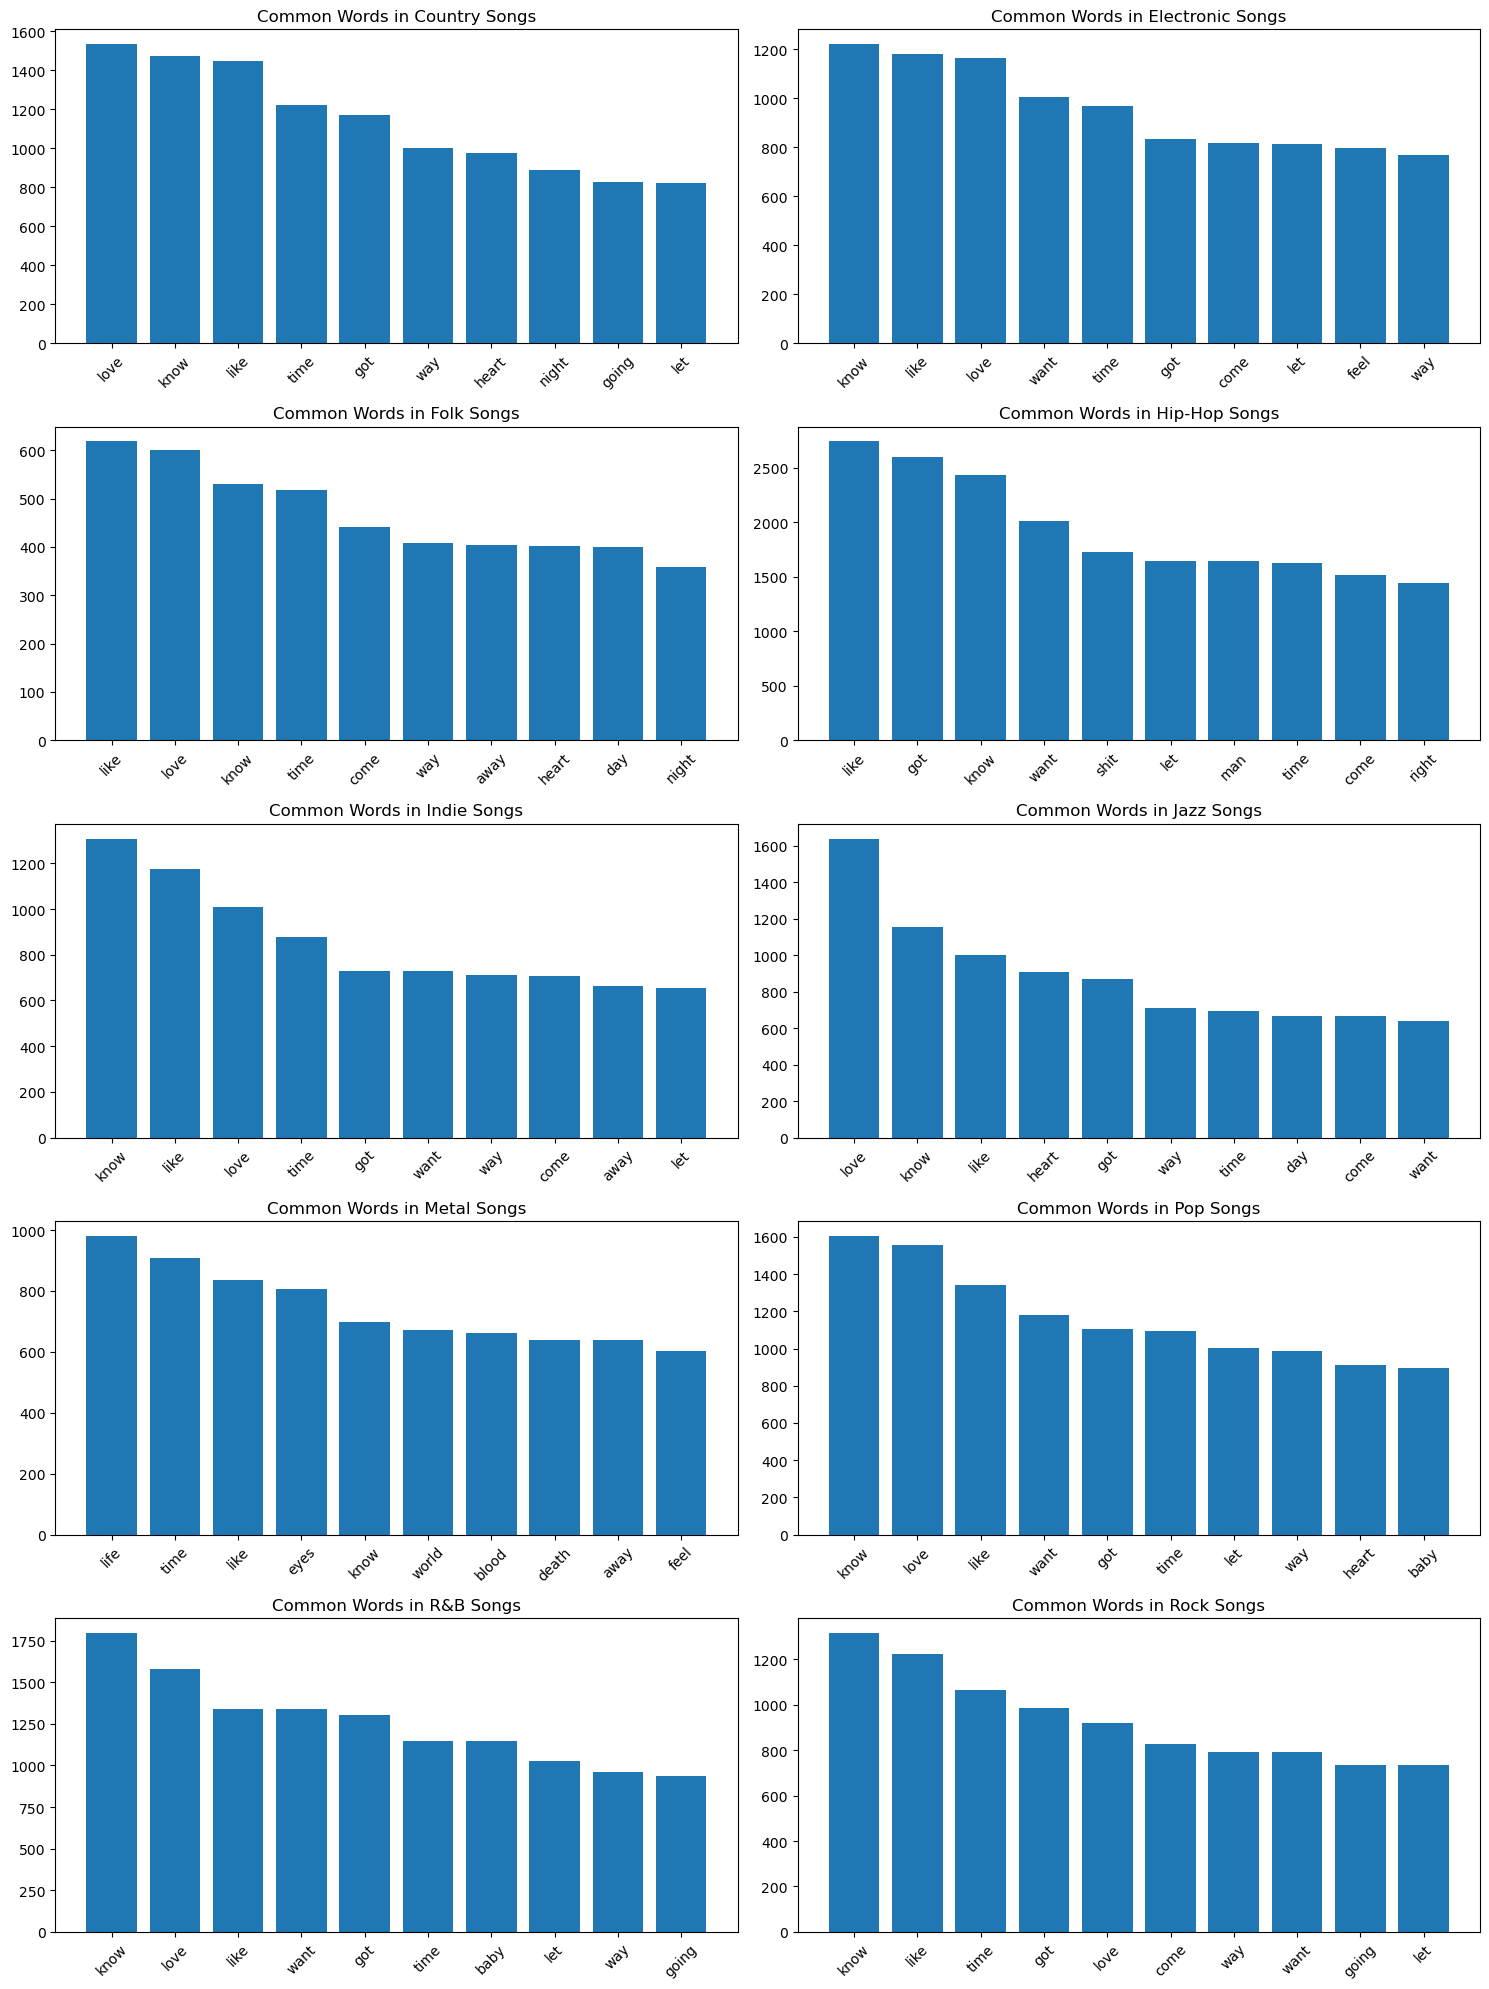

In [12]:
plot_common_words(balanced_df)

In [13]:
balanced_df['genre'].value_counts()

genre
Country       3390
Electronic    3390
Hip-Hop       3390
Jazz          3390
Metal         3390
Pop           3390
R&B           3390
Rock          3390
Indie         3101
Folk          2095
Name: count, dtype: int64

In [14]:
def words_frequency_treshhold(word_count, N):
    N_most_common_words = []
    for word, count in word_count.items():
        if count > N:
            N_most_common_words.append(word)
    return N_most_common_words

def remove_words(text, words_to_remove):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in words_to_remove]
    return ' '.join(filtered_tokens)

In [15]:
all_lyrics = ' '.join(balanced_df['processed_lyrics'])
words = all_lyrics.split()

word_count = Counter(words)

most_common_words = words_frequency_treshhold(word_count, 1900)

balanced_df['processed_lyrics'] = balanced_df['processed_lyrics'].apply(lambda lyrics: remove_words(lyrics, most_common_words))

/tmp/ipykernel_5155/2237043858.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=45)
/tmp/ipykernel_5155/2237043858.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=45)
/tmp/ipykernel_5155/2237043858.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=45)
/tmp/ipykernel_5155/2237043858.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=45)
/tmp/ipykernel_5155/2237043858.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.s

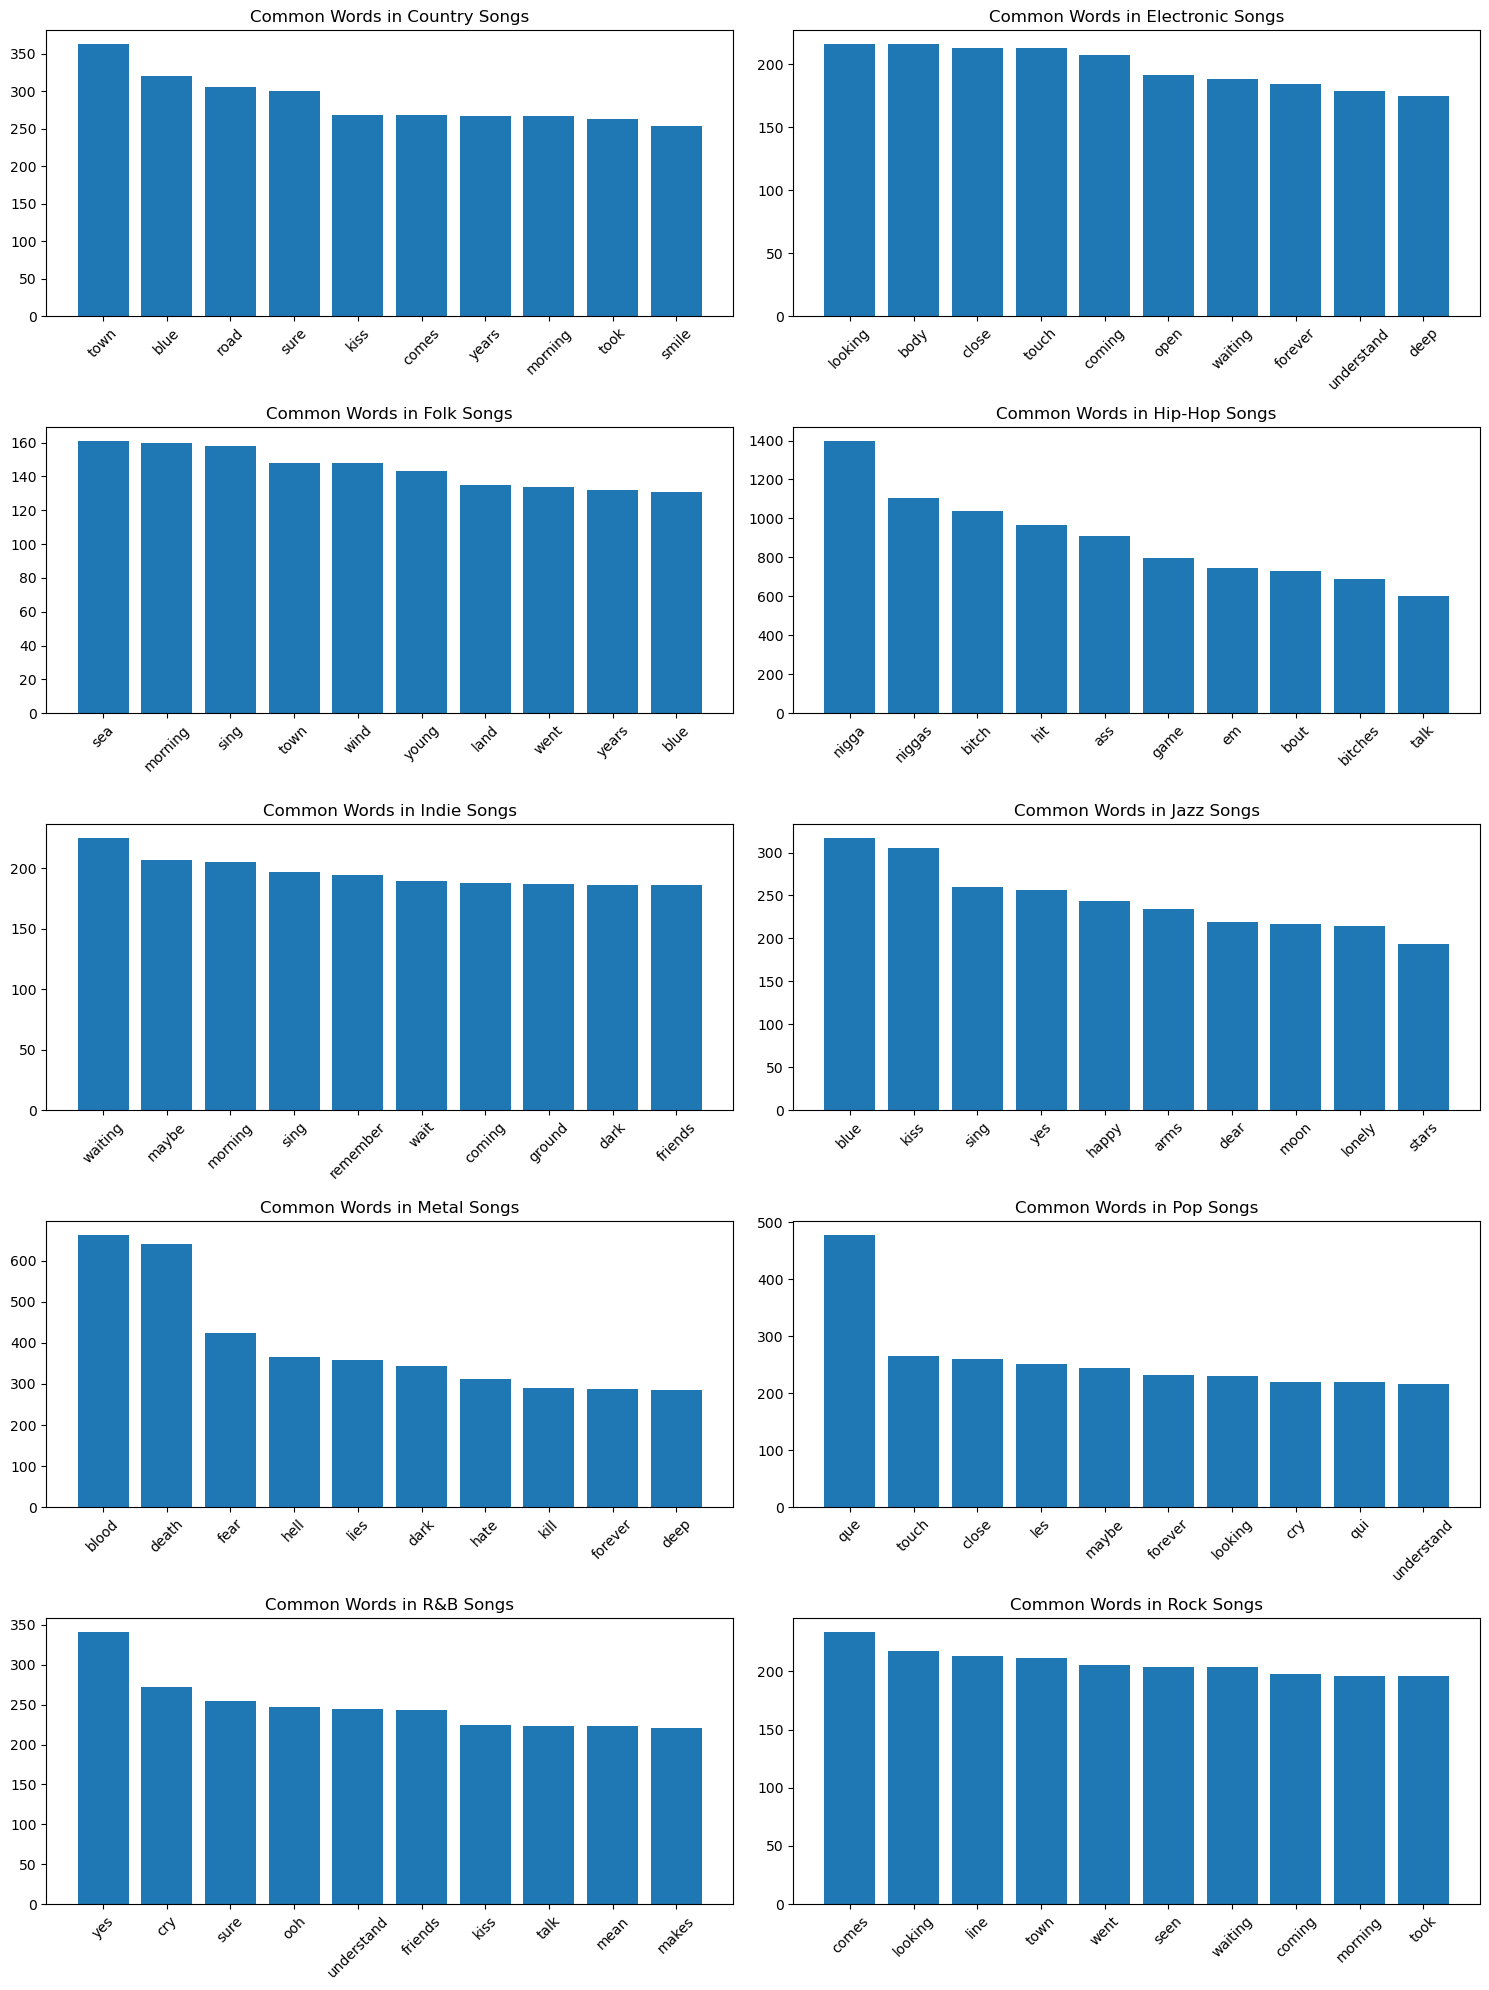

In [16]:
plot_common_words(balanced_df)

In [17]:
balanced_df['processed_lyrics'].to_csv('unbalanced_lyrics1900.txt', index=False, header=False)

In [18]:
embeddings_index = dict()
embeddings_dim = 300

f = open('./glove.6B/glove.6B.'+ str(embeddings_dim)  +'d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype=np.float16)
    embeddings_index[word] = coefs
f.close()

'''with open('vectors1500.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype=np.float32)
        embeddings_index[word] = coefs'''
        
tokenizer = Tokenizer()
tokenizer.fit_on_texts(balanced_df['processed_lyrics'])
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, embeddings_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
balanced_df['encoded_docs'] = tokenizer.texts_to_sequences(balanced_df['processed_lyrics'])

In [ ]:
df_filtred = balanced_df[balanced_df['encoded_docs'].apply(len) >= 14]
df_filtred['genre'].value_counts()

In [ ]:
treshhold = min(df_filtred['genre'].value_counts().tolist())
true_balanced_df = balance_classes(df_filtred, 'genre', treshhold)

In [ ]:
max_length_for_padding=[] 
for i in true_balanced_df['encoded_docs']:  
  max_length_for_padding.append(len(i))  
print(sorted(max_length_for_padding))

In [ ]:
true_balanced_df['encoded_docs']

In [ ]:
def plot_common_lyric_lengths(balanced_df, column_genre='genre', column_lyrics='encoded_docs'):
    genre_lengths = {}

    for genre in balanced_df[column_genre].unique():
        lengths = balanced_df[balanced_df[column_genre] == genre][column_lyrics].apply(len)
        genre_lengths[genre] = lengths

    # Criar subplots para os gráficos de barras
    num_genres = len(genre_lengths)
    fig, axs = plt.subplots((num_genres + 1) // 2, 2, figsize=(15, 20))
    axs = axs.flatten()

    # Plotar a distribuição dos comprimentos das letras para cada gênero
    for ax, (genre, lengths) in zip(axs, genre_lengths.items()):
        lengths.hist(ax=ax, bins=20)
        ax.set_title(f'Lyric Lengths in {genre} Songs')
        ax.set_xlabel('Length')
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [ ]:
plot_common_lyric_lengths(true_balanced_df)

In [ ]:
def plot_polar_genre_lengths(balanced_df, column_genre='genre', column_lyrics='encoded_docs'):
    """
    Plota um gráfico polar mostrando a média do comprimento das letras por gênero musical.

    :param balanced_df: DataFrame contendo as letras processadas e os gêneros musicais.
    :param column_genre: Nome da coluna que contém os gêneros musicais.
    :param column_lyrics: Nome da coluna que contém as letras processadas (como listas de números).
    """
    balanced_df['lyrics_length'] = balanced_df[column_lyrics].apply(len)

    # Depois, calcular a média do comprimento das letras por gênero
    genre_means = balanced_df.groupby(column_genre)['lyrics_length'].mean()

    # Ordenar os gêneros e valores
    genres = genre_means.index
    means = genre_means.values

    # Criar o gráfico polar
    num_genres = len(genres)
    angles = np.linspace(0, 2 * np.pi, num_genres, endpoint=False).tolist()
    means = np.concatenate((means, [means[0]]))  # fechar o gráfico
    angles += angles[:1]  # fechar o gráfico

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.fill(angles, means, color='red', alpha=0.25)
    ax.plot(angles, means, color='red', linewidth=2)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(genres, fontsize=12)

    ax.set_title('Average Lyric Length by Genre', size=20, color='red', y=1.1)
    plt.show()
    

In [ ]:
plot_polar_genre_lengths(true_balanced_df)